# Model validity checks

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

File ‘_if_on_colab_setup_flamedisx.ipynb’ already there; not retrieving.

TensorFlow 2.x selected.
Flamedisx is installed :-)


In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from multihist import Hist1d

import flamedisx
import tensorflow as tf

from flamedisx.x1t_sr0 import SR0NRSource, SR0ERSource, SR0WIMPSource

SR0ERSource.do_pel_fluct = True

class LowMassWIMPSource(SR0WIMPSource):
    mw = 30  # GeV

have_gpu = tf.test.is_gpu_available()
tf.__version__, have_gpu, tf.executing_eagerly()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.1.0-rc1', True, True)

1940 ER events
602 NR events


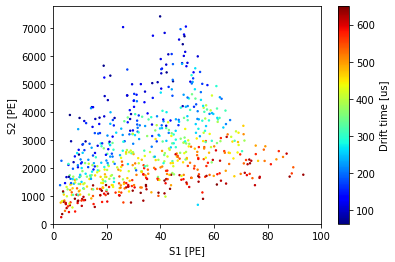

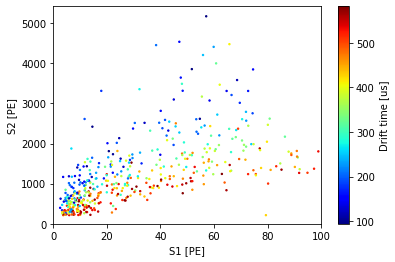

In [5]:
dsets = dict(
    er=dict(source_class=SR0ERSource,
            data=pd.read_csv('data_Rn220_lowenergy.csv')),
    nr=dict(source_class=LowMassWIMPSource,
            data=pd.read_csv('data_AmBe_lowenergy.csv')[::8]))

print(len(dsets['er']['data']), "ER events")
print(len(dsets['nr']['data']), "NR events")

def std_axes():
    plt.xlabel("S1 [PE]")
    plt.ylabel(r"S2 [PE]")
    plt.xlim(0, 100)
    plt.ylim(0, None)

for dname, q in dsets.items():
    d = q['data']
    sc = q['source_class']

    q['source'] = s = sc(d)  # batch_size
    d = s.annotate_data(d)

    # Cut at CES < 10.
    # a cs1 cut would likely cause a bias since for some energies
    # you'd only have some extreme events.
    d = q['data'] = d[d['e_vis'] < 10].copy()

    s.set_data(d)
    
    plt.scatter(d['s1'], d['s2'], s=2, c=d['drift_time']/1e3, cmap=plt.cm.jet)
    plt.colorbar(label="Drift time [us]")
    std_axes()
    plt.show()

# Compute differential rate

100%|██████████| 66/66 [00:05<00:00, 12.33it/s]
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


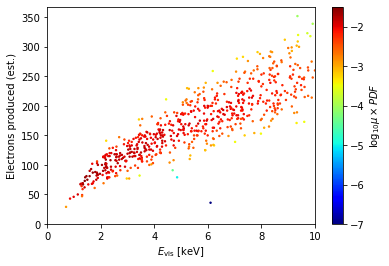

100%|██████████| 47/47 [00:01<00:00, 33.40it/s]


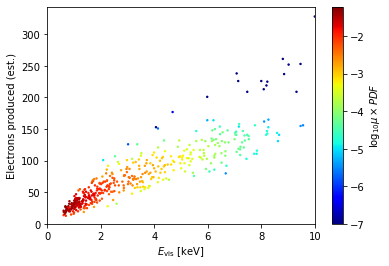

In [6]:
for dname, q in dsets.items():
    d = q['data']
    if 'likelihood' not in d.columns:
        d['likelihood'] = q['source'].batched_differential_rate()

    d['ll'] = np.log10(d['likelihood'])
        
    plt.scatter(d['e_vis'], 
                d['electron_produced_mle'],
                c=d['ll'], vmin=-7,
                cmap=plt.cm.jet, s=2)
    plt.colorbar(label=r'$\log_{10} \mu \times PDF$')

    plt.xlabel(r"$E_\mathrm{vis}$ [keV]")
    plt.ylabel("Electrons produced (est.)")
    plt.xlim(0, 10)
    plt.ylim(0, None)
    plt.show()

## Compare data with simulation

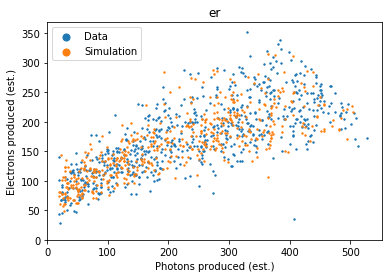

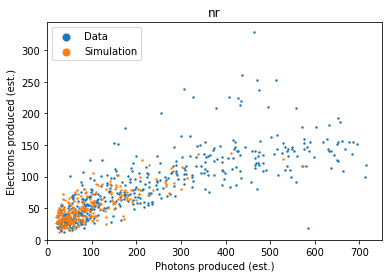

In [7]:
for dname, q in dsets.items():
    s = q['source']
    d = s.simulate(len(q['data']))
    
    d = d[d['e_vis'] < 10]
    q['data_sim'] = d
    
    for d, label in ([q['data'], 'Data'], [q['data_sim'], 'Simulation']):
        plt.scatter(d['photon_produced_mle'], d['electron_produced_mle'], 
                    label=label, s=2)
        
    plt.xlabel("Photons produced (est.)")
    plt.ylabel("Electrons produced (est.)")
    plt.legend(loc='upper left', markerscale=5)

    plt.title(dname)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.show()

The agreement is pretty good. Not perfect -- but that's not the point:
  * For ER, I didn't want to spend hours implementing the fine details of the SR0 ER model (such as the electron lifetime time distribution).
  * For NR, I don't know the AmBe energy spectrum, so I just compare with a high-mass WIMP. The agreement isn't great, but at least the NR band seems to be in approximately the right place, which is OK for now.

Though it's not much of a check (since it doens't involve the likelihood at all), we can also check whether the estimated and actual produced number of photons/electrons match:

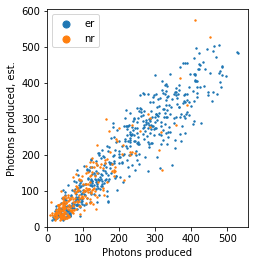

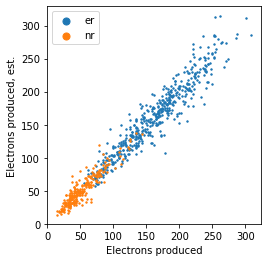

In [8]:
for qt in ['photon', 'electron']:
    for dname, q in dsets.items():
        d = q['data_sim']

        plt.scatter(d[f'{qt}_produced'], d[f'{qt}_produced_mle'], s=2, label=dname)
        plt.xlabel(f"{qt.capitalize()}s produced")
        plt.ylabel(f"{qt.capitalize()}s produced, est.")

    plt.legend(markerscale=5)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.gca().set_aspect('equal')
    plt.show()

and whether the min-max bounds are reasonable:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  


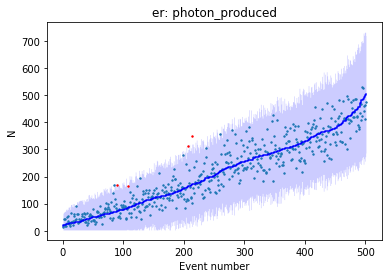

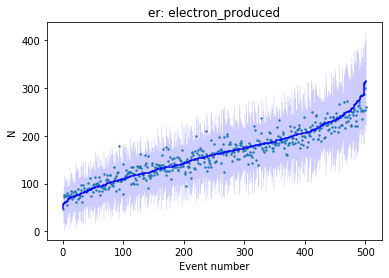

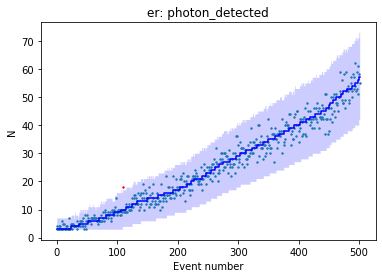

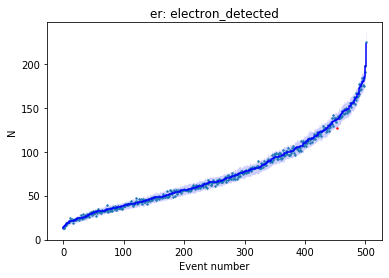

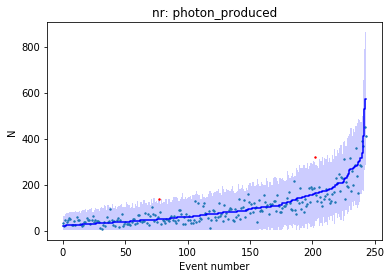

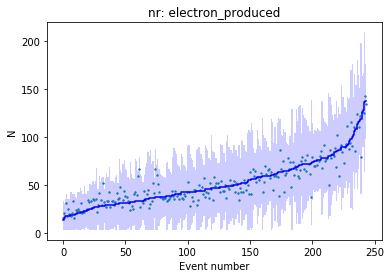

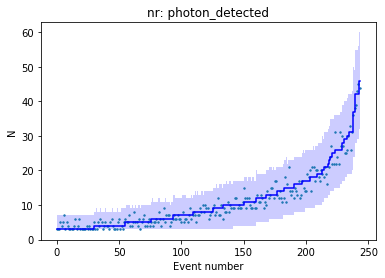

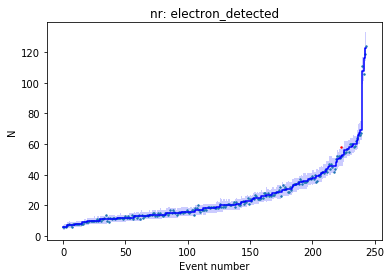

In [9]:
for dname, q in dsets.items():
    for kind in ('produced', 'detected'):
        for qt in ['photon', 'electron']:
            d = q['data_sim'].copy()
            key = qt + '_' + kind
            d = d.sort_values(by=[key + '_mle',
                                  key + '_min'])

            mi, ma, mle, real = d[[key + x 
                                   for x in ('_min', '_max', '_mle', '')]].values.T
            x = np.arange(len(d))
            plt.fill_between(x, ma, mi, 
                             step='mid', color='b', alpha=0.2, linewidth=0)
            plt.plot(x, mle, c='b', linestyle='steps-mid')
            
            fail = (real < mi) | (real > ma)
            plt.scatter(x[fail], real[fail], c='r', s=2)
            plt.scatter(x[~fail], real[~fail], s=2)

            plt.title(dname + ': ' + key)
            plt.xlabel("Event number")
            plt.ylabel("N")
            plt.show()

# Compare with MC likelihood

For this we have to simulate events at *one* position, so the likelihood becomes two-dimensional. Then we can build a histogram using the simulation, and convert it to a PDF estimate.

In [0]:
fix_truth = dict(x=0, y=0, z=-50)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


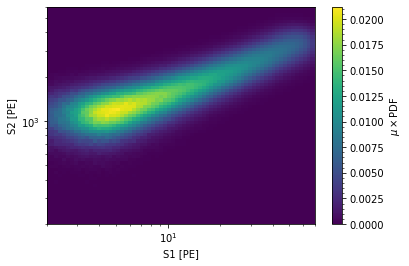

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


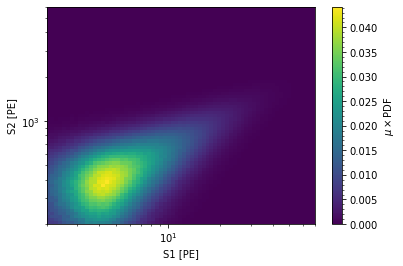

In [11]:
import flamedisx
from tqdm import tqdm
from multihist import Histdd

n_trials = int(1e5)
n_batches = 100
evt_i = 0

keys_to_fix = ['x', 'y', 'z', 'event_time']
single_event = dict()

for dname, q in dsets.items():
    # single_event[dname] = dsets[dname]['data'].iloc[evt_i]
    #del q['mh']
    if 'mh' in q:
        mh = q['mh']
    else:
        mh = Histdd(bins=(
            np.geomspace(2, 70, 70),
            np.geomspace(200, 6000, 70)))

        for _ in tqdm(range(n_batches)):
            _d = q['source'].simulate(n_trials,
                                      fix_truth=fix_truth)
            mh.add(_d['s1'], _d['s2'])

        # Convert to PDF
        mh /= mh.bin_volumes() * n_trials * n_batches
        
        # Multiply by total expected event rate
        # (from the source, i.e. before correcting for efficiencies)
        # The efficiency is correctly taken into account because we divide by 
        # the number of trials above, not the number of observed events.
        if dsets[dname]['source_class'] == SR0WIMPSource:
            mh *= q['source'].energy_hist.slice(single_event[dname]['t']).n
        else:
            mh *= q['source'].mu_before_efficiencies()
        
        q['mh'] = mh
        
    mh.plot(cblabel=r'$\mu \times \mathrm{PDF}$')
    plt.xlabel("S1 [PE]")
    plt.ylabel("S2 [PE]")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


  0%|          | 0/1652 [00:00<?, ?it/s]

er: throwing out 0.00% of sim events


100%|██████████| 1652/1652 [00:13<00:00, 123.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
  0%|          | 0/1108 [00:00<?, ?it/s]

nr: throwing out 0.00% of sim events


100%|██████████| 1108/1108 [00:07<00:00, 138.75it/s]


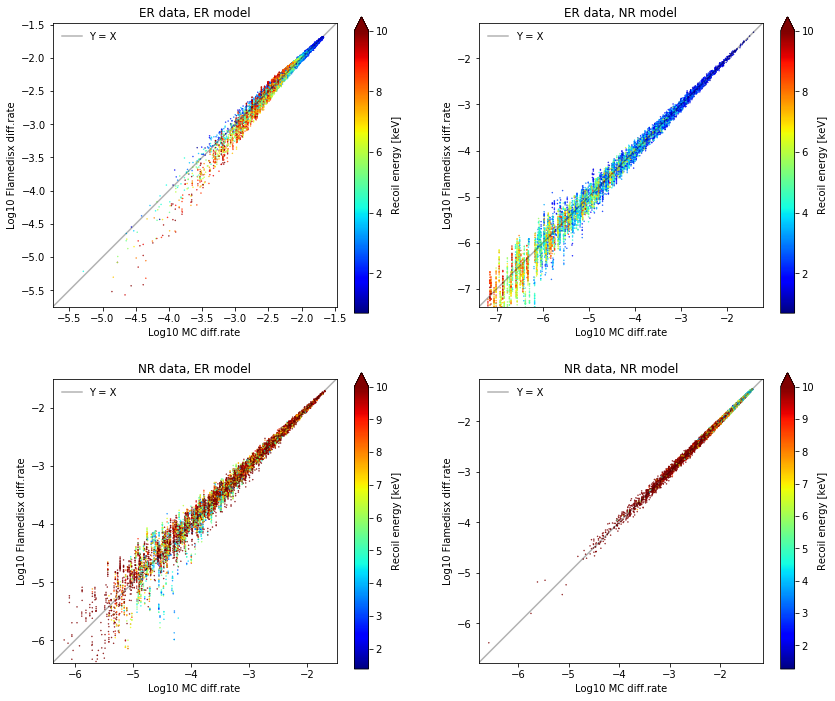

In [13]:
f, axes = plt.subplots(2, 2, figsize=(14, 12))

for data_i, (dname, q) in enumerate(dsets.items()):
    if 'simd' in q:
        d = q['simd']
    else:
        d = q['source'].simulate(int(2e4) if have_gpu else int(2e3), fix_truth=fix_truth)
        # Avoid extrapolation in MC likelihood
        mask = (
           (2 < d['s1']) & (d['s1'] < 70)
           & (200 < d['s2']) & (d['s2'] < 6000))
        print(f"{dname}: throwing out {100 * (~mask).sum()/len(mask):.2f}% of sim events")
        q['simd'] = d

        # Note the higher max_sigma here to ensure good results
        for _dn, _q in dsets.items():
            d[f'dr_{_dn}_mh'] = _q['mh'].lookup(d['s1'], d['s2'])
            d[f'dr_{_dn}_full'] = _q['source_class'](d, max_sigma=5).batched_differential_rate()

    for lh_i, (_dn, _q) in enumerate(dsets.items()):
        plt.sca(axes[data_i, lh_i])
        
        x, y = np.log10(d[f'dr_{_dn}_mh'].values), np.log10(d[f'dr_{_dn}_full'].values)
        plt.scatter(
            x, y,
            c=d['energy'], cmap=plt.cm.jet, vmax=10,
            s=0.2)
        xf = x[np.isfinite(x)]
        ma, mi = xf.max() + 0.2, xf.min() - 0.2
        plt.plot([mi, ma], [mi, ma], c='k', alpha=0.3, label='Y = X')
        plt.legend(loc='best', frameon=False)
        plt.xlim(mi, ma)
        plt.ylim(mi, ma)
    
        plt.colorbar(label='Recoil energy [keV]', extend='max')
        plt.xlabel("Log10 MC diff.rate")
        plt.ylabel("Log10 Flamedisx diff.rate")
        plt.gca().set_aspect('equal')
        plt.title(f"{dname.upper()} data, {_dn.upper()} model")

plt.savefig(f"fd_vs_mc_diffrates.png", bbox_inches='tight')
plt.show()

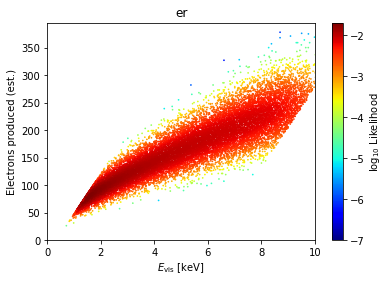

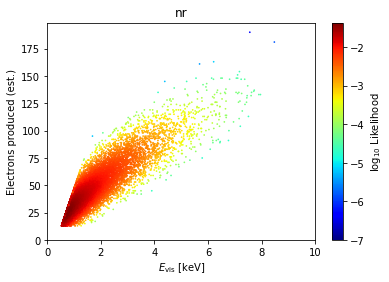

In [20]:
for dname, q in dsets.items():
    d = q['simd']
    
    plt.scatter(d['e_vis'], 
                d['electron_produced_mle'],
                c=np.log10(d[f'dr_{dname}_full']), vmin=-7,
                cmap=plt.cm.jet, s=0.5 if have_gpu else 2)
    plt.colorbar(label=r'$\log_{10}$ Likelihood')

    plt.xlabel(r"$E_\mathrm{vis}$ [keV]")
    plt.ylabel("Electrons produced (est.)")
    plt.xlim(0, 10)
    plt.ylim(0, None)
    plt.title(dname)



    plt.show()

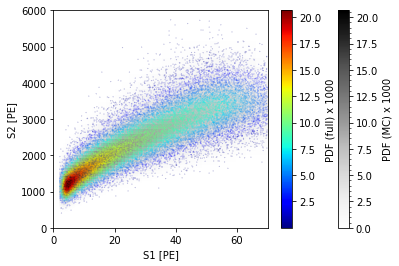

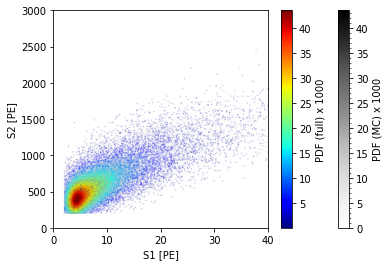

In [23]:
for dname, q in dsets.items():
    d = q['simd']

    lmax = d[f'dr_{dname}_full'].max()
    f = 1000
    
    (q['mh'] * f).plot(cmap=plt.cm.Greys, vmax=lmax * f, 
                       cblabel='PDF (MC) x %d' % f)
    
    plt.scatter(d['s1'], d['s2'], s=0.01 if have_gpu else 0.5, 
                c=f * d[f'dr_{dname}_full'], 
                cmap=plt.cm.jet, vmax=lmax * f)
    plt.colorbar(label='PDF (full) x %d' % f)
    plt.xlabel("S1 [PE]")
    plt.ylim(0, None if dname == 'er' else 3000)
    plt.xlim(0, None if dname == 'er' else 40)
    plt.ylabel("S2 [PE]")

    plt.show()